+ Pixelized shear measurements (smoothing -> pixelize/ pixelize -> smoothing)
+ Get the variance map (mock/analytical)

In [12]:
%pylab inline
import os
import gc
import matplotlib
import numpy as np
import astropy.io.fits as pyfits
import astropy.table as astTab
import massmap_utilities as mutilities
from configparser import ConfigParser
from pixel3D import cartesianGrid3D
from scipy.stats import norm as statnorm
import haloSim

Populating the interactive namespace from numpy and matplotlib


In [2]:
configName  =   'wrkDir/config-nl20.ini'
parser      =   ConfigParser()
parser.read(configName)
outDir      =   'wrkDir/pixel/'

In [22]:
fieldname='XMM'
infname='wrkDir/reGaus_catalog/%s.fits' %(fieldname)
data=pyfits.getdata(infname)
head=pyfits.getheader(infname,ext=1)
raMin=(head['ra_min']-3.)*60.
raMax=(head['ra_max']+3.)*60.
decMin=(head['dec_min']-3.)*60.
decMax=(head['dec_max']+3.)*60.
nx=int((raMax-raMin+1)//2*2)
ny=int((decMax-decMin+1)//2*2)
print(raMin,decMin)
parser.set('transPlane','xmin','%s'%raMin)
parser.set('transPlane','ymin','%s'%decMin)
parser.set('transPlane','nx','%d'%nx)
parser.set('transPlane','ny','%d'%ny)
gridInfo    =   cartesianGrid3D(parser)
x,y,z=data['ra'],data['dec'],data['dnn_zbest']
v=data['g1']+1j*data['g2']
ws=data['weight']
g1OutTmp=numpy.histogramdd((z,y,x),bins=(gridInfo.zbound,gridInfo.ybound,gridInfo.xbound), weights=v.real*ws)[0]
g2OutTmp=numpy.histogramdd((z,y,x),bins=(gridInfo.zbound,gridInfo.ybound,gridInfo.xbound), weights=v.imag*ws)[0]
weightOut=numpy.histogramdd((z,y,x),bins=(gridInfo.zbound,gridInfo.ybound,gridInfo.xbound), weights=ws)[0]
assert weightOut.shape==gridInfo.shape,'the output shape is different from expectation?'
if gridInfo.sigma>0:
    # smothing with Gausian Kernel
    gausKer=haloSim.GausAtom(ny=ny,nx=nx,sigma=gridInfo.sigma/gridInfo.delta,fou=True,lnorm=2.)
    norm=gausKer[0,0]
    gausKer/=norm
    g1OutTmp=np.fft.ifft2(np.fft.fft2(g1OutTmp)*gausKer).real
    g2OutTmp=np.fft.ifft2(np.fft.fft2(g2OutTmp)*gausKer).real
    weightOut=np.fft.ifft2(np.fft.fft2(weightOut)*gausKer).real
    
mask=weightOut>1.
g1Out=np.zeros(gridInfo.shape)
g1Out[mask]=g1OutTmp[mask]/weightOut[mask]
g2Out=np.zeros(gridInfo.shape)
g2Out[mask]=g2OutTmp[mask]/weightOut[mask]
varOut=np.zeros(gridInfo.shape,dtype=float)
# truncate the smoothing kernel

1565.6270882643864 -563.4529855801278


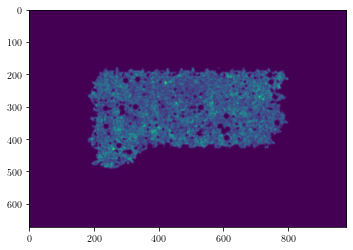

In [23]:
plt.imshow(weightOut[0])
pyfits.writeto('b.fits',weightOut,overwrite=True)

In [21]:
gridInfo.sigma/gridInfo.delta

1.5

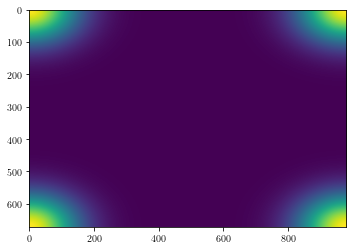

In [24]:
imshow(gausKer)

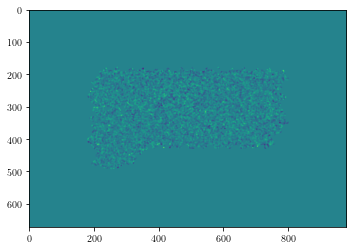

In [26]:
plt.imshow(g1Out[0])
pyfits.writeto('a.fits',g1Out,overwrite=True)

In [36]:
g1pixPlot.shape

(10, 672, 980)

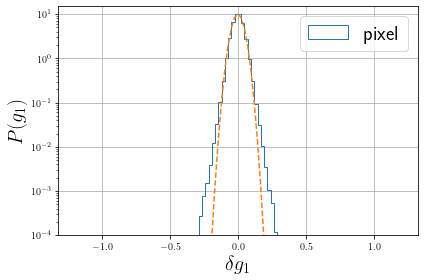

In [27]:
g1pixAll=g1Out[mask]
gbin=plt.hist(g1pixAll,bins=100,density=True,range=(-1.2,1.2),histtype='step',label='pixel')[1]
gbinPix=(gbin-np.average(g1pixAll))/np.std(g1pixAll)
a=statnorm.pdf(gbinPix)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),ls='--')
plt.xlabel(r'$\delta g_1$',fontsize=20)
plt.ylabel(r'$P(g_1)$',fontsize=20)
plt.legend(fontsize=20)
plt.yscale('log')
plt.ylim(1e-4,15)
plt.grid()
plt.tight_layout()

In [4]:
for fieldname in mutilities.field_names:
    print(fieldname)
    infname='wrkDir/reGaus_catalog/%s.fits' %(fieldname)
    data=pyfits.getdata(infname)
    head=pyfits.getheader(infname,ext=1)
    raMin=(head['ra_min']-3.)*60.
    raMax=(head['ra_max']+3.)*60.
    decMin=(head['dec_min']-3.)*60.
    decMax=(head['dec_max']+3.)*60.
    nx=int(raMax-raMin+1)
    ny=int(decMax-decMin+1)
    print(raMin,decMin)
    parser.set('transPlane','xmin','%s'%raMin)
    parser.set('transPlane','ymin','%s'%decMin)
    parser.set('transPlane','nx','%d'%nx)
    parser.set('transPlane','ny','%d'%ny)
    gridInfo    =   cartesianGrid3D(parser)
    v=data['g1']+1j*data['g2']
    g1g2    =   gridInfo.pixelize_data(data['ra'],data['dec'],data['dnn_zbest'],v,ws=data['weight'])
    if True:
        break
    else:
        g1fname     =   os.path.join(outDir,'pixShearR-g1-%s.fits' %fieldname)
        g2fname     =   os.path.join(outDir,'pixShearR-g2-%s.fits' %fieldname)
        pyfits.writeto(g1fname,g1g2.real,overwrite=True)
        pyfits.writeto(g2fname,g1g2.imag,overwrite=True)
        del g1g2,data
        gc.collect()

XMM
1565.6270882643864 -563.4529855801278


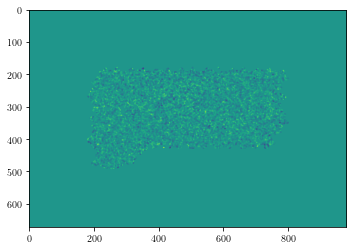

In [6]:
plt.imshow(g1g2.real[0])

In [8]:
g1fname     =   os.path.join(outDir,'pixShearR-g1-%s.fits' %fieldname)
g2fname     =   os.path.join(outDir,'pixShearR-g2-%s.fits' %fieldname)
pyfits.writeto(g1fname,g1g2.real,overwrite=True)
pyfits.writeto(g2fname,g1g2.imag,overwrite=True)

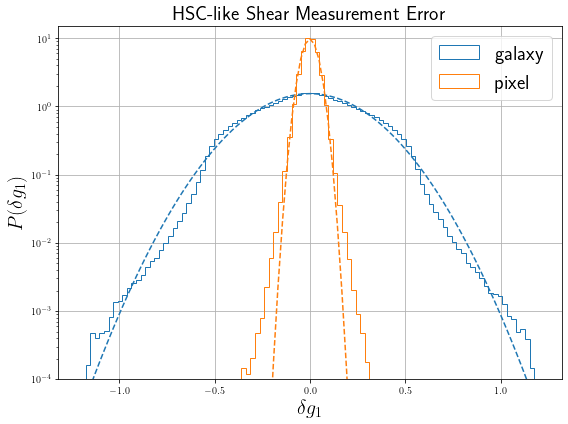

In [13]:
cmap=plt.get_cmap('tab20')


plt.figure(figsize=(8,6))

gbin=plt.hist(data['g1'],bins=100,density=True,range=(-1.2,1.2),histtype='step',label='galaxy',color=cmap(0))[1]
gbinGal=(gbin-np.average(data['g1']))/np.std(data['g1'])
a=norm.pdf(gbinGal)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(0),ls='--')

g1pixAll=g1g2.real
g1pixAll=g1pixAll[g1pixAll!=0]
gbin=plt.hist(g1pixAll,bins=100,density=True,range=(-1.2,1.2),histtype='step',label='pixel',color=cmap(2))[1]

gbinPix=(gbin-np.average(g1pixAll))/np.std(g1pixAll)
a=norm.pdf(gbinPix)
plt.plot(gbin,a/np.sum(a)/(gbin[1]-gbin[0]),color=cmap(2),ls='--')
plt.title('HSC-like Shear Measurement Error',fontsize=20)
plt.xlabel(r'$\delta g_1$',fontsize=20)
plt.ylabel(r'$P(\delta g_1)$',fontsize=20)
plt.legend(fontsize=20)
plt.yscale('log')
plt.ylim(1e-4,15)
plt.grid()
plt.tight_layout()

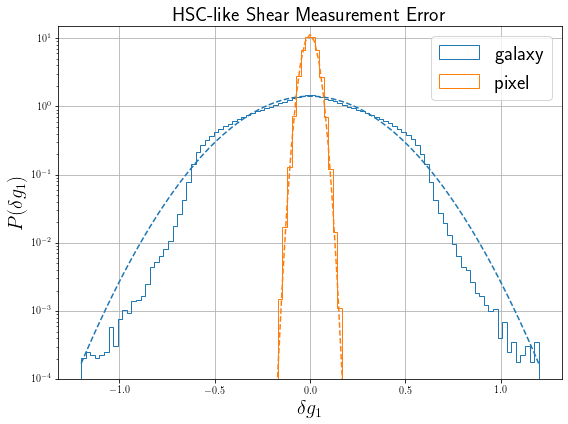

In [79]:
# simulation results
plt.savefig('../doc/paper_ms_method_HSCY1/shapeMeasurementError-HSCY1.pdf')